# PWave/Noise Classification Using a Random Forest Classifier

## Introduction

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
from datetime import datetime, time, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Constants. Change as needed.
file_path = "data/scsn_p_2000_2017_6sec_0.5r_pick_train_mix.hdf5"
features_key = 'X'
labels_key = 'pwave'

n_models = 35
# dataset_size = 100000
# dataset_size = 50000
dataset_size = 5000
test_size = 0.2
random_state = 0

In [3]:
# Open the file,
file = h5py.File(file_path, 'r')

# read the file and store the relevant data into numpy.ndarrays,
dataset = file.get(features_key)[:dataset_size]
labels = file.get(labels_key)[:dataset_size]

# split the data into training and validation sets,
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=test_size, random_state = 0)

# then close the file.
file.close()

In [4]:
# Let's feature scale so that large values don't overpower small values.
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [5]:
"""
Model Parameters
We want to see how the model performs when these vary.
 
n_estimators: In general, the larger the better.
  However, the larger it is, the longer it takes to compute and at some point, it stops improving the model.

max_features: The more the better. But impacts speed and can at some point be detrimental.
  For classification, a good default is sqrt(n_features).
  sklearn.models.RandomForestClassifier defaults this to 'auto'.
"""
n_estimators = 25
n_estimators_step = 25
# max_features = sqrt(len(dataset[0]))

In [6]:
# Time to train the models and generate the metrics needed to evaluate their performances.
classifiers = []
train_time = time(0)
for x in range(n_models):
    # Record the passage of time (how long does it take to train one model and how long does it take for a trained model to make predictions).
    train_time = datetime.now()
    
    # Define the model.
    n_e = n_estimators + n_estimators_step * x
    classifier = RandomForestClassifier(
        n_estimators=n_e,
        random_state=random_state
    )

    # Train the model,
    classifier.fit(X_train, y_train)
    # have it predict some stuff from the test data,
    validation_time = datetime.now()
    y_pred = classifier.predict(X_test)
    validation_time = datetime.now() - validation_time
    # generate the models metrics,
    classifier_metadata = {
        "validation_time": validation_time.total_seconds(),
        "n_estimators": n_e,
        "train_accuracy": metrics.accuracy_score(y_train, classifier.predict(X_train)),
        "test_accuracy": metrics.accuracy_score(y_test, y_pred),
        "mae": metrics.mean_absolute_error(y_test, y_pred),
        "mse": metrics.mean_squared_error(y_test, y_pred),
        "rmse": np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    }
    # then add the model and its metrics to the list of classifiers.
    classifiers.append({
        "classifier": classifier,
        "classifier_metadata": classifier_metadata
    })
    
    # Record the passage of time.
    
    train_time = (datetime.now() - train_time).total_seconds()

    print(f"Model no. {x} (no. estimators: {n_e}) completed in {train_time}.")

Model no. 0 (no. estimators: 25) completed in 3.651218.
Model no. 1 (no. estimators: 50) completed in 7.742273.
Model no. 2 (no. estimators: 75) completed in 10.308438.
Model no. 3 (no. estimators: 100) completed in 14.072373.
Model no. 4 (no. estimators: 125) completed in 16.895825.
Model no. 5 (no. estimators: 150) completed in 20.139152.
Model no. 6 (no. estimators: 175) completed in 23.856213.
Model no. 7 (no. estimators: 200) completed in 27.939296.
Model no. 8 (no. estimators: 225) completed in 32.85216.
Model no. 9 (no. estimators: 250) completed in 35.840547.
Model no. 10 (no. estimators: 275) completed in 40.198144.
Model no. 11 (no. estimators: 300) completed in 41.313616.
Model no. 12 (no. estimators: 325) completed in 44.731761.
Model no. 13 (no. estimators: 350) completed in 36.836026.
Model no. 14 (no. estimators: 375) completed in 27.7129.
Model no. 15 (no. estimators: 400) completed in 29.568939.
Model no. 16 (no. estimators: 425) completed in 31.957552.
Model no. 17 (n

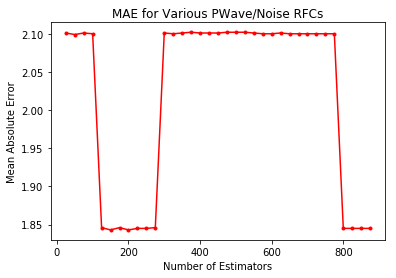

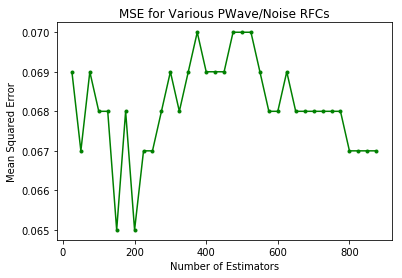

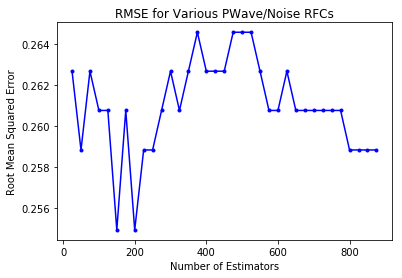

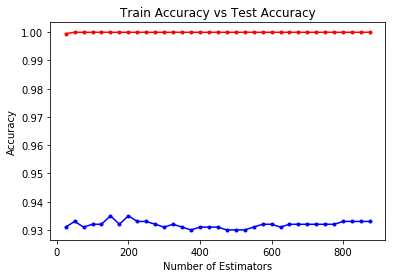

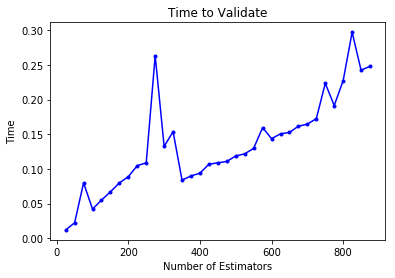

In [8]:
# Finally, let's look at the metrics.

# Define the independent variable.
x = np.arange(n_estimators, n_estimators + n_models * n_estimators_step, n_estimators_step)

# Mean Absolute Error
plt.title("MAE for Various PWave/Noise RFCs")
plt.xlabel('Number of Estimators')
plt.ylabel("Mean Absolute Error")
y = []
for classifier in classifiers:
    y.append(classifier['classifier_metadata']['mae'])
plt.plot(x, y, 'r.-')
plt.show()

# Mean Squared Error
plt.title("MSE for Various PWave/Noise RFCs")
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Squared Error")
y = []
for classifier in classifiers:
    y.append(classifier['classifier_metadata']['mse'])
plt.plot(x, y, 'g.-')
plt.show()

# Root Mean Squared Error
plt.title("RMSE for Various PWave/Noise RFCs")
plt.xlabel("Number of Estimators")
plt.ylabel("Root Mean Squared Error")
y = []
for classifier in classifiers:
    y.append(classifier['classifier_metadata']['rmse'])
plt.plot(x, y, 'b.-')
plt.show()

# Train Accuracy vs Test Accuracy
plt.title("Train Accuracy vs Test Accuracy")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
y1 = []
y2 = []
for classifier in classifiers:
    y1.append(classifier['classifier_metadata']['train_accuracy'])
    y2.append(classifier['classifier_metadata']['test_accuracy'])
plt.plot(x, y1, 'r.-')
plt.plot(x, y2, 'b.-')
plt.show()

# Time to Validate
plt.title("Time to Validate")
plt.xlabel("Number of Estimators")
plt.ylabel("Time")
y = []
for classifier in classifiers:
    y.append(classifier['classifier_metadata']['validation_time'])
plt.plot(x, y, 'b.-')
plt.show()

## Appendix

## Resources
* [1.11 Ensemble Methods (Scikit-Learn)](https://scikit-learn.org/stable/modules/ensemble.html)
* [Random Forest Algorithm With Python and Scikit-Learn (Stack Abuse)](https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/)